<a href="https://colab.research.google.com/github/EgorSolovei/Computer-Vision/blob/main/simpson_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download data from Kaggle

In [1]:
%%capture
! pip install kaggle

In [2]:
! mkdir ~/.kaggle

In [3]:
! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle competitions download -c journey-springfield

100% 520M/521M [00:23<00:00, 31.7MB/s]
100% 521M/521M [00:23<00:00, 23.2MB/s]


In [6]:
%%capture
! unzip /content/journey-springfield.zip  # разархивировали файл

In [7]:
! ls testset/
! ls train/simpsons_dataset/

testset
abraham_grampa_simpson	  edna_krabappel	marge_simpson	     professor_john_frink
agnes_skinner		  fat_tony		martin_prince	     rainier_wolfcastle
apu_nahasapeemapetilon	  gil			mayor_quimby	     ralph_wiggum
barney_gumble		  groundskeeper_willie	milhouse_van_houten  selma_bouvier
bart_simpson		  homer_simpson		miss_hoover	     sideshow_bob
carl_carlson		  kent_brockman		moe_szyslak	     sideshow_mel
charles_montgomery_burns  krusty_the_clown	ned_flanders	     snake_jailbird
chief_wiggum		  lenny_leonard		nelson_muntz	     troy_mcclure
cletus_spuckler		  lionel_hutz		otto_mann	     waylon_smithers
comic_book_guy		  lisa_simpson		patty_bouvier
disco_stu		  maggie_simpson	principal_skinner


# Data processing

In [8]:
import torch
import torchvision
import pickle
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
import seaborn as sns
import random

from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from matplotlib import colors, pyplot as plt
%matplotlib inline

In [9]:
train_on_gpu = torch.cuda.is_available()

if train_on_gpu:
    print('CUDA is available. Training on GPU')
else:
    print('CUDA is not available! Training on CPU')

CUDA is available. Training on GPU


In [10]:
!nvidia-smi

torch.cuda.is_available()

Tue Feb  6 16:01:04 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8               9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

True

## Augmentation
https://www.kaggle.com/code/marinalakeeva/data-augmentation

In [11]:
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [12]:
train_val_labels = [path.parent.name for path in train_val_files]

In [13]:
len(test_files), len(train_val_files)

(991, 20933)

In [14]:
len(set(train_val_labels)) # 42 класса

42

In [15]:
def get_count(labels):
    df = pd.DataFrame(labels, columns=['name'])
    df['count'] = 1
    return df.groupby('name').count().sort_values('count')

In [16]:
def show_data(data, min_level=True, max_level=True):
    plt.figure(figsize=(15, 9))
    sns.barplot(x=data.index, y=data['count'], orient='v').set_xticklabels(data.index, rotation=90)
    if max_level:
        plt.axhline(y=1500)
    if min_level:
        plt.axhline(y=100, color='red')
    plt.show()

In [17]:
data = get_count(train_val_labels)

<ipython-input-16-2cc3ef361042>:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  sns.barplot(x=data.index, y=data['count'], orient='v').set_xticklabels(data.index, rotation=90)


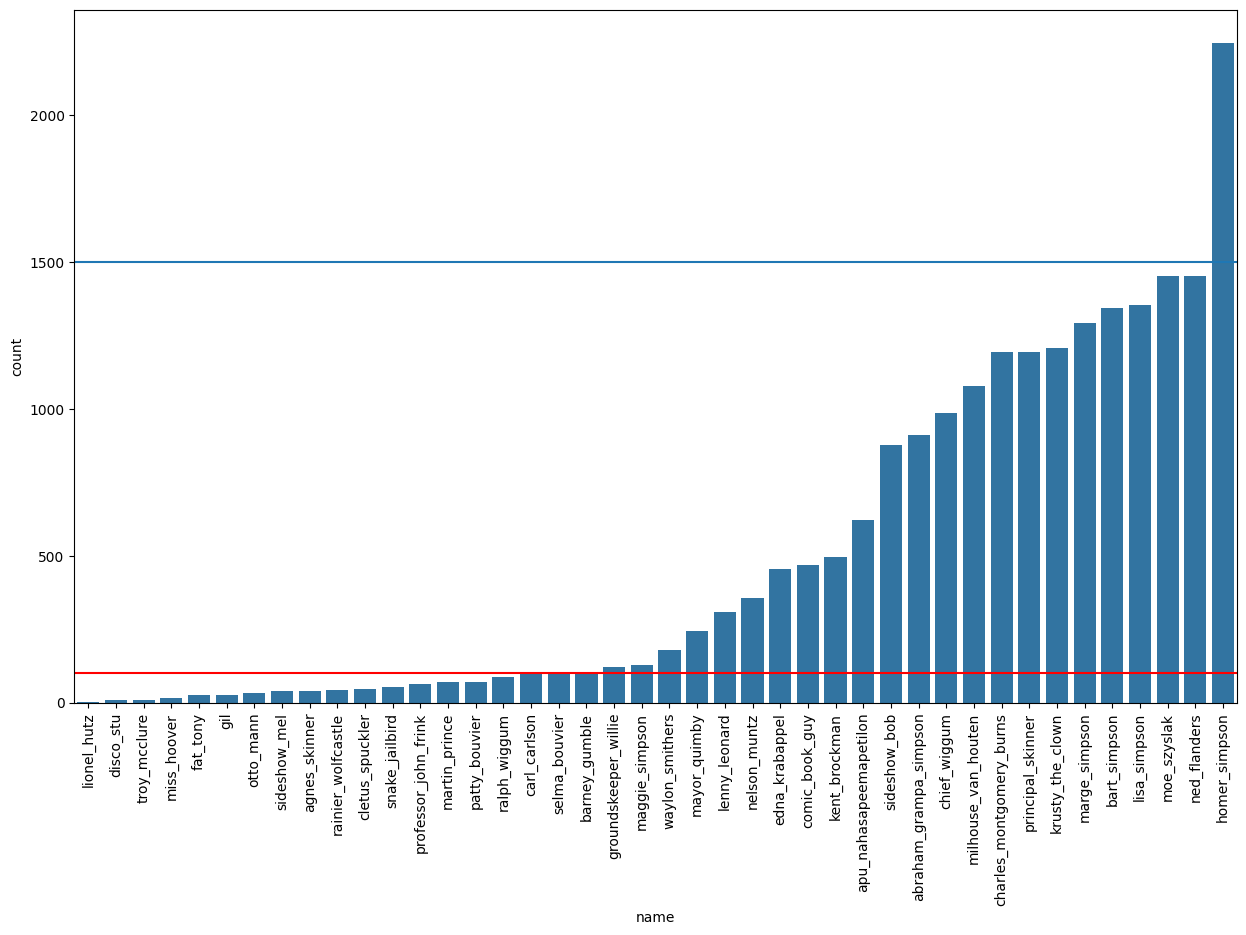

In [18]:
show_data(data)

In [19]:
import math

# создадим сколько нужно добавить фотографий и сколько итераций необходимо сделать до 1500 фотографий
data['to_add'] = data['count'].apply(lambda x: 1500 - x if x < 1500 else 0)
data['one_iteration'] = data.apply(lambda x: math.ceil(x['to_add'] / x['count']), axis=1)
data.head()

,count,to_add,one_iteration
name,,,
lionel_hutz,3,1497,499
disco_stu,8,1492,187
troy_mcclure,8,1492,187
miss_hoover,17,1483,88
fat_tony,27,1473,55


In [20]:
augmenters = {
    'Crop': transforms.Compose([
                                transforms.Resize(size=300, max_size=301),
                                transforms.CenterCrop(size=300),
                                transforms.RandomCrop(250)
                                ]),
    'Rotate': transforms.RandomRotation(degrees=(-25, 25)),
    'HFlip': transforms.RandomHorizontalFlip(p=1)
}

In [21]:
def load_image(file):
    image = Image.open(file)
    image.load()
    return image

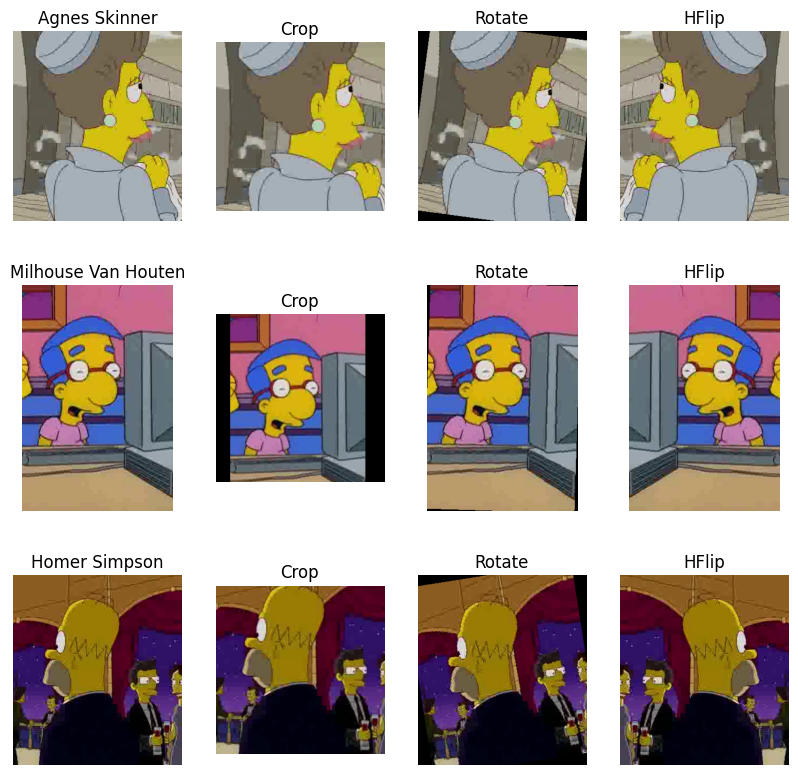

In [22]:
n_examples = 3

fig, ax = plt.subplots(nrows=n_examples, ncols=(len(augmenters) + 1), figsize=(10, 10))

for i in range(n_examples):
    random_character = int(np.random.uniform(0, len(train_val_files)))
    img_orig = load_image(train_val_files[random_character])
    img_label = train_val_files[random_character].parent.name

    img_label = " ".join(map(lambda x: x.capitalize(), img_label.split('_')))
    ax[i][0].imshow(img_orig)
    ax[i][0].set_title(img_label)
    ax[i][0].axis('off')

    for j, (augmenter_name, augmenter) in enumerate(augmenters.items()):
        img_aug = augmenter(img_orig)
        ax[i][j + 1].imshow(img_aug)
        ax[i][j + 1].set_title(augmenter_name)
        ax[i][j + 1].axis('off')

In [23]:
for image_path in tqdm(train_val_files):
    path = image_path.parents[0]
    character = image_path.parent.name
    img = load_image(image_path)
    # if we don't need to add any images, we can continue without transformation
    if data.loc[character]['to_add'] <= 0:
        continue

    # if number of images to create for one iteration is greater than the rest of images to create,
    # we should use 'to_add' instead of 'one_iteration'
    if data.loc[character]['one_iteration'] > data.loc[character]['to_add']:
        iter_size = data.loc[character]['to_add']
    else:
        iter_size = data.loc[character]['one_iteration']
    data.loc[character]['to_add'] -= iter_size

    for i in range(iter_size):
        augmenter = random.choice(list(augmenters.values()))
        aug_img = augmenter(img)
        aug_img.save(f"{path}/{image_path.name.split('.')[0]}_{i}.jpg")

100%|██████████| 20933/20933 [01:42<00:00, 204.96it/s]


In [24]:
aug_files = sorted(list(TRAIN_DIR.rglob('*.jpg'))) # файлы после аугментации
aug_labels = [path.parent.name for path in aug_files]
aug_data = get_count(aug_labels)

<ipython-input-16-2cc3ef361042>:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  sns.barplot(x=data.index, y=data['count'], orient='v').set_xticklabels(data.index, rotation=90)


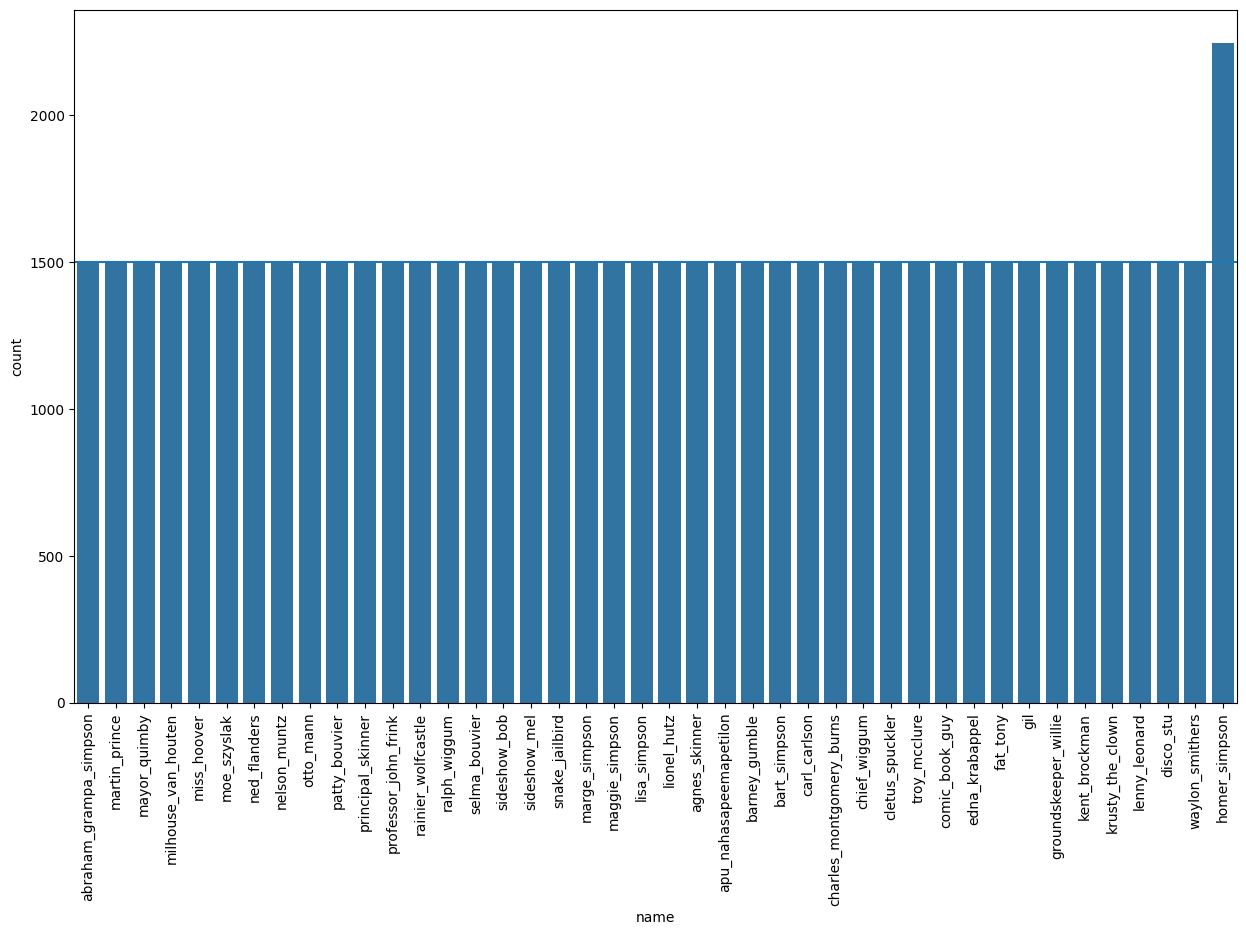

In [25]:
show_data(aug_data, min_level=False)

In [26]:
aug_data['count'].sum(), len(aug_files) # общее количество картинок

(63746, 63746)

## Data preprocessing

In [27]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']

# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224

# работаем на видеокарте
DEVICE = torch.device("cuda")

In [28]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        self.files = sorted(files) # список файлов для загрузки
        self.mode = mode # режим работы

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [29]:
from sklearn.model_selection import train_test_split

train_files, val_files = train_test_split(aug_files, test_size=0.25, stratify=aug_labels)

In [30]:
# состоит из кортежей, где на 0 позиции тензор, а на 1 класс
val_dataset = SimpsonsDataset(val_files, mode='val')
train_dataset = SimpsonsDataset(train_files, mode='train')

In [31]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

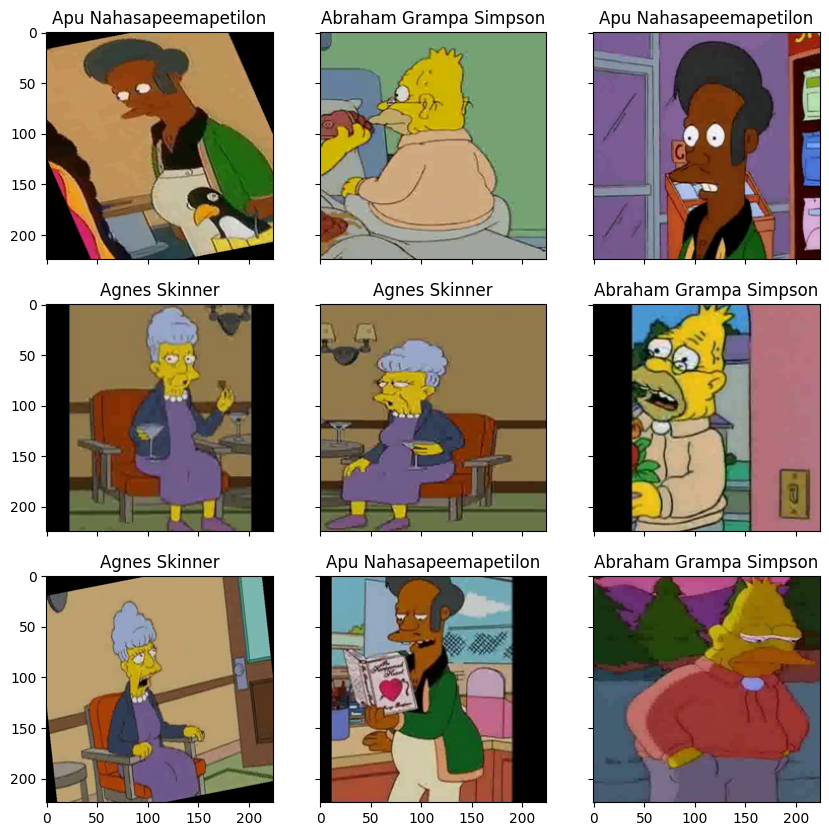

In [32]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(10, 10), sharey=True, sharex=True)

for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(), \
                             val_dataset.label_encoder.inverse_transform([label])[0].split('_')))

    imshow(im_val.data.cpu(), title=img_label,plt_ax=fig_x)

# Сonstruction CNN

In [33]:
class SimpleCNN(nn.Module):

    def __init__(self, n_classes):
        super().__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(8)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(16)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(32)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(64)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        self.out = nn.Linear(96 * 5 * 5, n_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)

        return logits

In [34]:
# тренировка на обучающемся множестве

def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward() # считает градиенты
        optimizer.step() # делаем шаг по оптимизатору
        optimizer.zero_grad()

        preds = torch.argmax(outputs, 1) # здесь выбираем максимальную "вероятность" из предсказанных нейронкой классов
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data) # считаем сумму правильно предсказанных классов
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [35]:
# проверка на валидационном множестве

def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)

    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [36]:
# тренировка модели вместе с построением графиков loss и accuracy
def train(train_data, val_data, model, epochs=6, batch_size=64):

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

    learning_rate = 3e-4
    opt = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    loss_fun = nn.CrossEntropyLoss()

    history = []

    for epoch in range(epochs):
        print(f"Start epoch №{epoch + 1}")
        train_loss, train_acc = fit_epoch(model, train_loader, loss_fun, opt) # тренировка
        print(f"Train loss: {train_loss:0.4f} \t\tTrain accuracy: {train_acc:0.4f}")

        val_loss, val_acc = eval_epoch(model, val_loader, loss_fun) # проверка на val части
        print(f"Validation loss: {val_loss:0.4f} \tValidation accuracy: {val_acc:0.4f}")
        history.append((train_loss, train_acc, val_loss, val_acc))

    # построим кривые обучения
    loss, acc, val_loss, val_acc = zip(*history)

    # график потерь
    plt.figure(figsize=(10, 6))
    plt.plot(loss, label="train_loss")
    plt.plot(val_loss, label="val_loss")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.show()

    # в val_acc лежит Tensor на gpu, поэтому его нужно перевести, чтобы построить график
    val_acc_list = [val_acc_score.to('cpu').numpy() for val_acc_score in val_acc]

    # график accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(acc, label="acc")
    plt.plot(val_acc_list, label="val_acc")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("acc")
    plt.show()

    print("Train is done!")

In [37]:
train_dataset = SimpsonsDataset(train_files, mode='train')
val_dataset = SimpsonsDataset(val_files, mode='val')

Start epoch №1
Train loss: 1.4683 		Train accuracy: 0.6252
Validation loss: 0.8408 	Validation accuracy: 0.7820
Start epoch №2
Train loss: 0.6148 		Train accuracy: 0.8397
Validation loss: 0.5610 	Validation accuracy: 0.8501
Start epoch №3
Train loss: 0.3668 		Train accuracy: 0.9025
Validation loss: 0.4036 	Validation accuracy: 0.8905
Start epoch №4
Train loss: 0.2393 		Train accuracy: 0.9341
Validation loss: 0.3432 	Validation accuracy: 0.9086
Start epoch №5
Train loss: 0.1685 		Train accuracy: 0.9525
Validation loss: 0.3220 	Validation accuracy: 0.9149
Start epoch №6
Train loss: 0.1195 		Train accuracy: 0.9658
Validation loss: 0.3061 	Validation accuracy: 0.9211


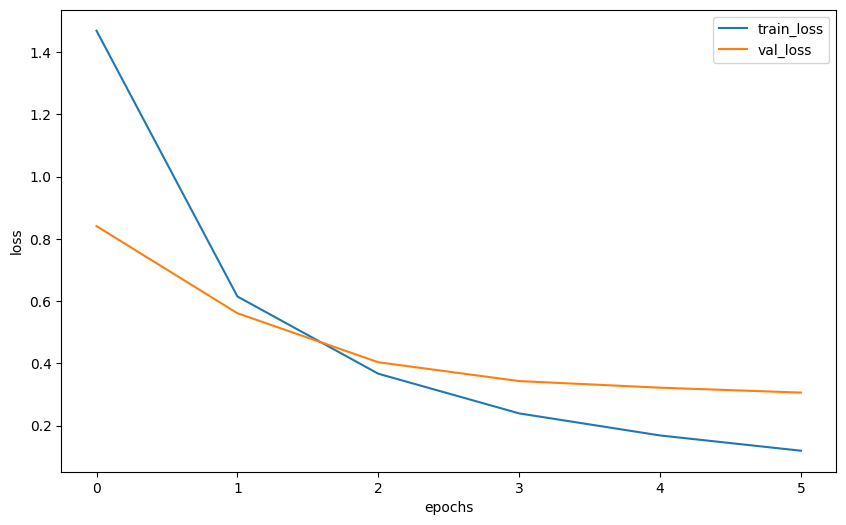

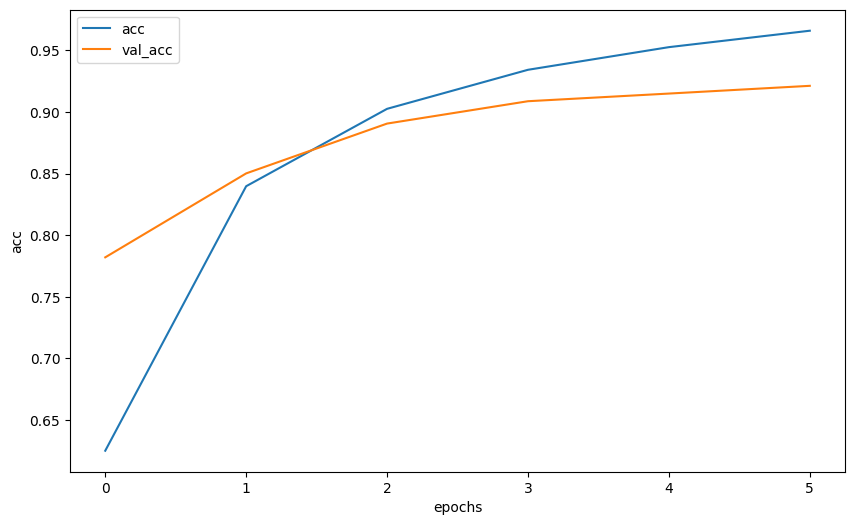

Train is done!


In [38]:
# обучение самодельной сети
cnn_model = SimpleCNN(42).to(DEVICE)

train(train_dataset, val_dataset, model=cnn_model, batch_size=64)

In [39]:
# # так можно посмотреть что конкретно лежит в одном батче

# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# train_features, train_labels = next(iter(train_loader))
# train_features[0], train_labels.shape

# Transfer learning

In [59]:
alex_model = torchvision.models.alexnet(weights="IMAGENET1K_V1")

In [60]:
alex_model # арехитектура сети

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

## Fine Tuning способ
Мы обучаем все слои загруженной нейронки (то есть все свертки) и меняем только часть FC - классификатор - для своей задачи. Также можем поменять оптимизатор и функцию потерь

In [42]:
feature_in = 9216 # количество входных нейронов

alex_model.classifier = nn.Linear(feature_in, 42) # меняем архитектуру под свою задачу

In [43]:
alex_model # изменили архитектуру

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Linear(in_features=9216, out_features=42, bias=True)
)

In [44]:
alex_model = alex_model.cuda()

Start epoch №1
Train loss: 0.7701 		Train accuracy: 0.8002
Validation loss: 0.3007 	Validation accuracy: 0.9211
Start epoch №2
Train loss: 0.1295 		Train accuracy: 0.9640
Validation loss: 0.2112 	Validation accuracy: 0.9450
Start epoch №3
Train loss: 0.0658 		Train accuracy: 0.9805
Validation loss: 0.2064 	Validation accuracy: 0.9494
Start epoch №4
Train loss: 0.0550 		Train accuracy: 0.9839
Validation loss: 0.1797 	Validation accuracy: 0.9601
Start epoch №5
Train loss: 0.0619 		Train accuracy: 0.9816
Validation loss: 0.1929 	Validation accuracy: 0.9556
Start epoch №6
Train loss: 0.0438 		Train accuracy: 0.9876
Validation loss: 0.1934 	Validation accuracy: 0.9606


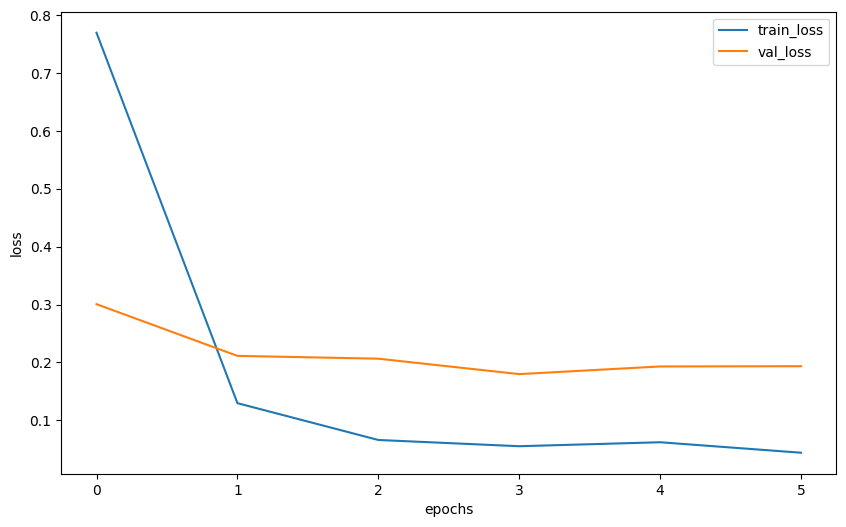

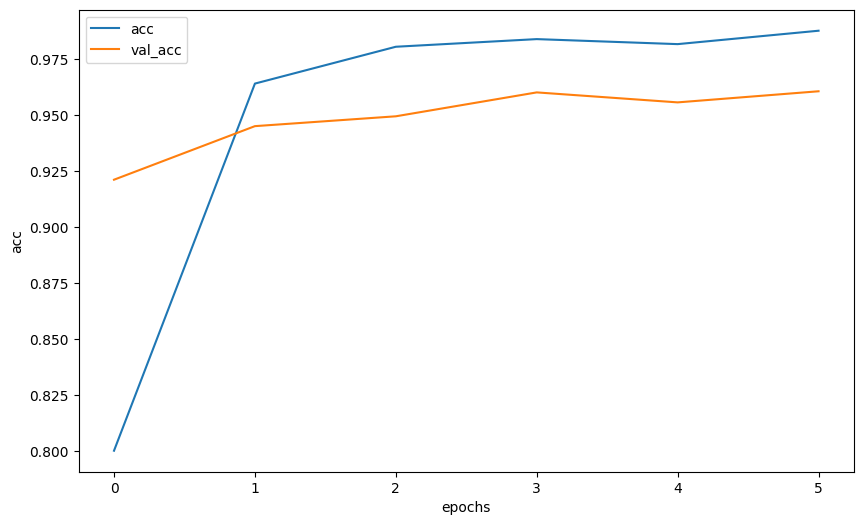

Train is done!


In [45]:
train(train_dataset, val_dataset, model=alex_model)

## Feature extractor способ


In [46]:
# все слои нейронки обучаеются заново для задачи
for param in alex_model.parameters():
    print(param.requires_grad)

True
True
True
True
True
True
True
True
True
True
True
True


In [47]:
# замораживаем параметры (веса)
for param in alex_model.parameters():
    param.requires_grad = False

## Смешанный способ.
Заморозим только несколько последний слоёв.

In [48]:
from pandas._config import option_context
layers_to_unfreeze = 5

# Выключаем подсчет градиентов для слоев, которые не будем обучать
for param in alex_model.features[:-layers_to_unfreeze].parameters():
    param.requires_grad = False

# Обучаем последние layers_to_unfreeze слоев из сверточной части и fully connected слой
# parameters() возвращает просто список тензоров параметров, поэтому два таких списка можно сложить
optimizer = torch.optim.Adam(list(alex_model.features.parameters())[-layers_to_unfreeze:] +
                             list(alex_model.classifier.parameters()), lr=1e-4)

# F1 score

Хорошо бы понять, как сделать сабмит.
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [49]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()

    return probs

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке.

In [50]:
from sklearn.metrics import f1_score

label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

def f1_score_test(model):
    idxs = list(map(int, np.random.uniform(0,1000, 400)))
    imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

    probs_ims = predict(model, imgs) # 42 числа с вероятностью каждого класса

    y_pred = np.argmax(probs_ims,-1) # предсказанный класс в численном представлении

    actual_labels = [val_dataset[id][1] for id in idxs] # ответы классов в численном представлении

    preds_class = [label_encoder.classes_[i] for i in y_pred] # класс именем персонажа

    print(f1_score(actual_labels, y_pred, average='micro'))

In [51]:
f1_score_test(alex_model)

0.97


In [52]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [53]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(alex_model, ex_img.unsqueeze(0))

Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

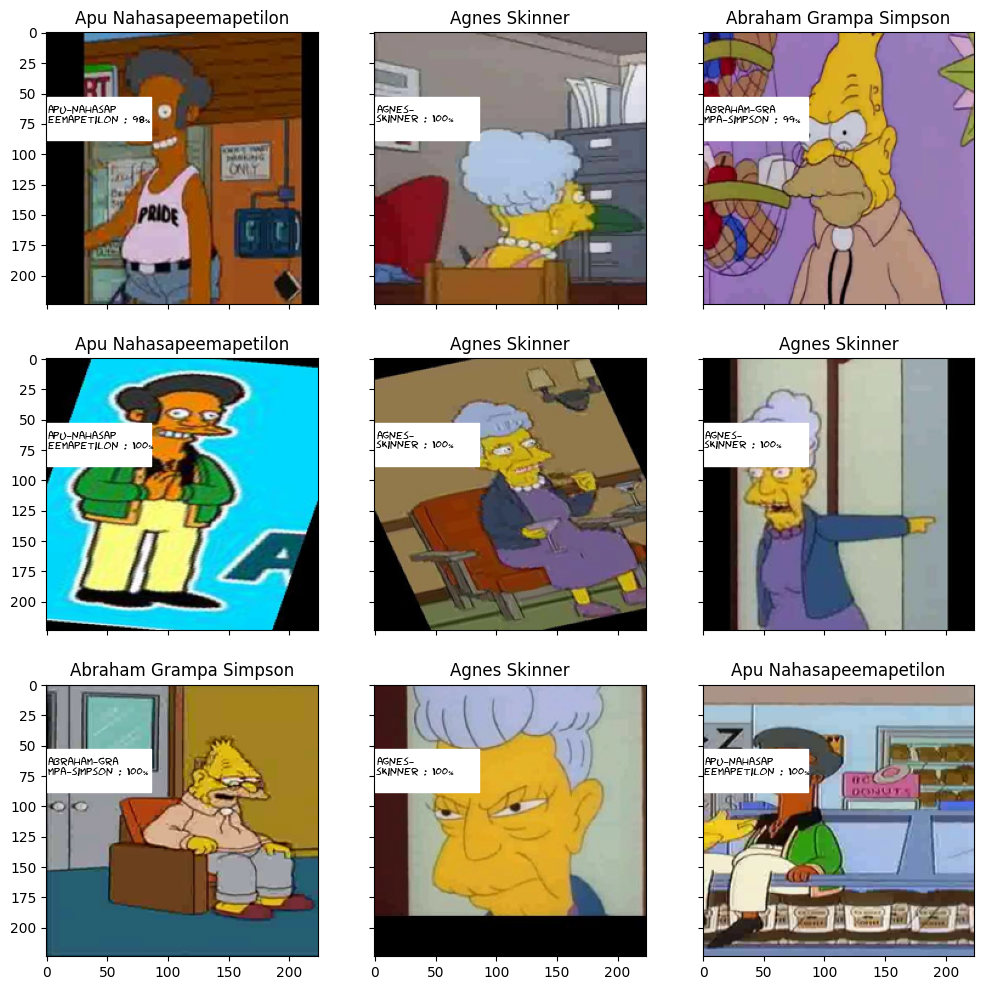

In [54]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))


    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(cnn_model, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)

    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

# Submit на Kaggle

In [55]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(alex_model, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [56]:
import pandas as pd

my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [57]:
my_submit.to_csv('submit_simpsons.csv', index=False)